In [1]:

#imports
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

sns.set()


#Modeling 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
import pickle


from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from collections import Counter




import warnings
warnings.filterwarnings('ignore')




In [2]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head(3)

df = df.drop(3116).reset_index().drop(columns='index') # index 3116 has gender 'Other', only one value

In [ ]:
df.isna().sum()

In [3]:
    
# 0 - Underweight; 1 - Healthy; 2 - Overweight; 3 - Obese
df['obesity'] = 'Underweight'
df['obesity'].loc[df['bmi'] > 18 ] = 'Healthy'
df['obesity'].loc[df['bmi'] > 25 ] = 'Overweight'
df['obesity'].loc[df['bmi'] > 30 ] = 'Obese'

# 0 - Low; 1 - Normal; 2 - Diabetic
df['diabetic'] = 'Low'
df['diabetic'].loc[df['avg_glucose_level'] > 60 ] = 'Normal'
df['diabetic'].loc[df['avg_glucose_level'] > 125 ] = 'Diabetic'

In [4]:
# #imputing the missing values with the mean
# =============================================================================
df = df.fillna(np.mean(df['bmi']))
df.info()

df = df[(df['age'] > 30)]
df = df.dropna()
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5109 entries, 0 to 5108
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5109 non-null   int64  
 1   gender             5109 non-null   object 
 2   age                5109 non-null   float64
 3   hypertension       5109 non-null   int64  
 4   heart_disease      5109 non-null   int64  
 5   ever_married       5109 non-null   object 
 6   work_type          5109 non-null   object 
 7   Residence_type     5109 non-null   object 
 8   avg_glucose_level  5109 non-null   float64
 9   bmi                5109 non-null   float64
 10  smoking_status     5109 non-null   object 
 11  stroke             5109 non-null   int64  
 12  obesity            5109 non-null   object 
 13  diabetic           5109 non-null   object 
dtypes: float64(3), int64(4), object(7)
memory usage: 558.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3540 entrie

In [5]:
df = df.drop(columns=['avg_glucose_level', 'bmi'], axis=1)
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke,obesity,diabetic
0,9046,Male,67.0,0,1,Yes,Private,Urban,formerly smoked,1,Obese,Diabetic
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,never smoked,1,Underweight,Diabetic
2,31112,Male,80.0,0,1,Yes,Private,Rural,never smoked,1,Obese,Normal
3,60182,Female,49.0,0,0,Yes,Private,Urban,smokes,1,Obese,Diabetic
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,never smoked,1,Healthy,Diabetic
...,...,...,...,...,...,...,...,...,...,...,...,...
3535,18234,Female,80.0,1,0,Yes,Private,Urban,never smoked,0,Underweight,Normal
3536,44873,Female,81.0,0,0,Yes,Self-employed,Urban,never smoked,0,Obese,Diabetic
3537,19723,Female,35.0,0,0,Yes,Self-employed,Rural,never smoked,0,Obese,Normal
3538,37544,Male,51.0,0,0,Yes,Private,Rural,formerly smoked,0,Overweight,Diabetic


In [6]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df = df.apply(le.fit_transform)
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke,obesity,diabetic
0,476,1,36,0,1,1,1,1,1,1,1,0
1,2507,0,30,0,0,1,2,0,2,1,3,0
2,1496,1,49,0,1,1,1,0,2,1,1,2
3,2919,0,18,0,0,1,1,1,3,1,1,0
4,77,0,48,1,0,1,2,0,2,1,0,0


In [7]:
df = df.drop(columns=['id'], axis=1)
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke,obesity,diabetic
0,1,36,0,1,1,1,1,1,1,1,0
1,0,30,0,0,1,2,0,2,1,3,0
2,1,49,0,1,1,1,0,2,1,1,2
3,0,18,0,0,1,1,1,3,1,1,0
4,0,48,1,0,1,2,0,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
3535,0,49,1,0,1,1,1,2,0,3,2
3536,0,50,0,0,1,2,1,2,0,1,0
3537,0,4,0,0,1,2,0,2,0,1,2
3538,1,20,0,0,1,1,0,1,0,2,0


In [8]:
from sklearn.model_selection import train_test_split
def split_data(df):
    '''
    Takes in a DataFrame and splits it into 60%/20%/20% for train,
    validate, and test DataFrames using random_rate=19
    '''

    # split data into train, validate, and test datasets
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=19)
    train, validate = train_test_split(train_validate, test_size=0.25,
                                            random_state=19)

    return train, validate, test
train, validate, test=split_data(df)

In [9]:
def split_xy(train, validate, test, target):
    '''
    Takes in the three train, validate, and test DataFrames and returns
    six X, y DataFrames after splitting the target from the X data
    '''

    # split train into X, y
    X_train = train.drop(columns=target)
    y_train = pd.DataFrame(train[target])
    # split validate into X, y
    X_validate = validate.drop(columns=target)
    y_validate = pd.DataFrame(validate[target])
    # split test into X, y
    X_test = test.drop(columns=target)
    y_test = pd.DataFrame(test[target])

    return X_train, y_train, X_validate, y_validate, X_test, y_test

In [10]:
X_train, y_train, X_validate, y_validate, X_test, y_test = split_xy(train, validate, test, 'stroke')
X_train

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,obesity,diabetic
2034,1,8,0,0,1,1,0,3,0,2
2702,1,33,1,0,1,1,1,1,1,2
1989,1,11,0,0,0,0,0,2,1,1
22,0,48,0,0,1,2,1,2,2,0
3091,0,48,1,0,1,2,0,2,2,2
...,...,...,...,...,...,...,...,...,...,...
1371,1,8,0,0,1,1,1,0,1,0
2126,0,24,1,0,1,1,1,1,1,0
2019,1,26,0,0,1,1,0,2,1,2
901,1,34,0,0,1,1,1,3,2,2


In [11]:
from imblearn.combine import SMOTETomek 


#Make variables from split data for smote processing

oversample = SMOTETomek(random_state=123)
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

In [15]:
print(X_train_smote.shape)
print(y_train_smote)

(3916, 10)
      stroke
0          0
1          0
2          0
3          1
4          0
...      ...
3911       1
3912       1
3913       1
3914       1
3915       1

[3916 rows x 1 columns]


In [16]:
# combine target to DataFrame for exploration
train = pd.concat((X_train_smote, y_train_smote.stroke), axis=1)

In [17]:
def target_heat(df, target, method='pearson'):
    '''
    Use seaborn to create heatmap with coeffecient annotations to
    visualize correlation between all variables
    '''

    # define variable for corr matrix
    heat_churn = df.corr()[target][:-1]
    # set figure size
    fig, ax = plt.subplots(figsize=(30, 1))
    # define cmap for chosen color palette
    cmap = sns.diverging_palette(h_neg=220, h_pos=13, sep=25, as_cmap=True)
    # plot matrix turned to DataFrame
    sns.heatmap(heat_churn.to_frame().T, cmap=cmap, center=0,
                annot=True, fmt=".1g", cbar=False, square=True)
    #  improve readability of xticks, remove churn ytick
    plt.xticks(ha='right', va='top', rotation=35, rotation_mode='anchor')
    plt.yticks(ticks=[])
    # set title and print graphic
    plt.title(f'Correlation to {target}\n')
    plt.show()


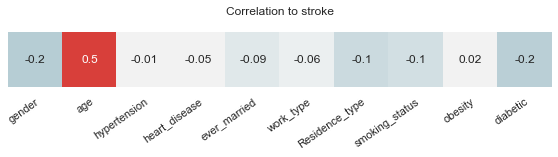

In [18]:
target_heat(train, 'stroke')

In [19]:
# set col_list for cluster formation
col_list = ['age', 'heart_disease', 'obesity']

explore_df = train[col_list]
explore_df = pd.DataFrame(explore_df, columns=explore_df.columns, index=explore_df.index)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 6156.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 6156.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 6156.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 6156.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 6156.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 44, cost: 4875.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 21, cost: 5884.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...


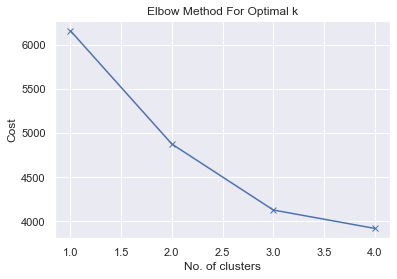

In [20]:
# Elbow curve to find optimal K
# Importing Libraries

from kmodes.kmodes import KModes
cost = []
K = range(1,5)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=1)
    kmode.fit_predict(explore_df)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [21]:
def explore_clusters(df, col_list, k=2):
    '''
    Takes in a DataFrame, column list, and optional integer value for
    k to create clusters for the purpose of exploration, returns a
    DataFrame containing cluster group numbers and cluster centers
    '''

    # create kmeans object
    kmode = KModes(n_clusters=2, init = "random", n_init = 2, verbose=1)
    # fit kmeans
    kmode.fit_predict(df[col_list])
    # store predictions
    cluster_df = pd.DataFrame(kmode.fit_predict(df[col_list]), index=df.index,
                                                        columns=['cluster'])
    cluster_df = pd.concat((df[col_list], cluster_df), axis=1)
    # store centers
    center_df = cluster_df.groupby('cluster')[col_list].agg(pd.Series.mode)
    
    return cluster_df, center_df, kmode

In [22]:
cluster_df, center_df, kmode=explore_clusters(explore_df, ['age', 'heart_disease', 'obesity'], k=3)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 6112.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 120, cost: 5256.0
Best run was number 2
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 5, cost: 5893.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 161, cost: 5256.0
Best run was number 2


In [23]:
cluster_df

,age,heart_disease,obesity,cluster
0,8,0,0,1
1,33,0,1,0
2,11,0,1,0
3,48,0,2,0
4,48,0,2,0
...,...,...,...,...
3911,50,0,2,0
3912,48,0,3,0
3913,26,0,1,0
3914,47,0,0,1


In [24]:
def plot_three_d_clusters(cluster_df, center_df, x_var, y_var, z_var):
    '''
    Takes in cluster and centers DataFrame created by explore_clusters
    function and creates a three dimesnional plot of the passed x, y,
    and z variables that make up that cluster group with different
    colors
    '''

    # set figure and axes
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111, projection='3d')    
    # set clusters for each cluster passed in arguments
    # set x, y, z for cluster 0
    x0 = cluster_df[cluster_df['cluster'] == 0][x_var]
    y0 = cluster_df[cluster_df['cluster'] == 0][y_var]
    z0 = cluster_df[cluster_df['cluster'] == 0][z_var]
    # set x, y, z for cluster 1
    x1 = cluster_df[cluster_df['cluster'] == 1][x_var]
    y1 = cluster_df[cluster_df['cluster'] == 1][y_var]
    z1 = cluster_df[cluster_df['cluster'] == 1][z_var]
    # set x, y, z for each additional cluster
    if len(center_df) > 2:
        x2 = cluster_df[cluster_df['cluster'] == 2][x_var]
        y2 = cluster_df[cluster_df['cluster'] == 2][y_var]
        z2 = cluster_df[cluster_df['cluster'] == 2][z_var]
    if len(center_df) > 3:
        x3 = cluster_df[cluster_df['cluster'] == 3][x_var]
        y3 = cluster_df[cluster_df['cluster'] == 3][y_var]
        z3 = cluster_df[cluster_df['cluster'] == 3][z_var]
    if len(center_df) > 4:
        x4 = cluster_df[cluster_df['cluster'] == 4][x_var]
        y4 = cluster_df[cluster_df['cluster'] == 4][y_var]
        z4 = cluster_df[cluster_df['cluster'] == 4][z_var]
    if len(center_df) > 5:
        x5 = cluster_df[cluster_df['cluster'] == 5][x_var]
        y5 = cluster_df[cluster_df['cluster'] == 5][y_var]
        z5 = cluster_df[cluster_df['cluster'] == 5][z_var]
        
    # set centers for each cluster passed in arguments
    # set centers for clusters 0, 1
    zero_center = center_df[center_df.index == 0]
    one_center = center_df[center_df.index == 1]
    # set centers for each additional clusters
    if len(center_df) > 2:
        two_center = center_df[center_df.index == 2]
    if len(center_df) > 3:
        three_center = center_df[center_df.index == 3]
    if len(center_df) > 4:
        four_center = center_df[center_df.index == 4]
    if len(center_df) > 5:
        five_center = center_df[center_df.index == 5]
    if len(center_df) > 6:
        six_center = center_df[center_df.index == 6]
        
    # plot clusters and their centers for each cluster passed in arguments
    # plot cluster 0 with center
    ax.scatter(x0, y0, z0, s=100, c='c', edgecolor='k', marker='o',
                                                    label='Cluster 0')
    ax.scatter(zero_center[x_var], zero_center[y_var], zero_center[z_var],
                                    s=300, c='c', marker='$\\bar{x}$')
    # plot cluster 1 with center
    ax.scatter(x1, y1, z1, s=100, c='y', edgecolor='k', marker='o',
                                                    label='Cluster 1')
    ax.scatter(one_center[x_var], one_center[y_var], one_center[z_var],
                                    s=300, c='y', marker='$\\bar{x}$')
    # plot each additional cluster passed in arguments
    if len(center_df) > 2:
        ax.scatter(x2, y2, z2, s=100, c='m', edgecolor='k', marker='o',
                                                    label='Cluster 2')
        ax.scatter(two_center[x_var], two_center[y_var], two_center[z_var],
                                    s=300, c='m', marker='$\\bar{x}$')
    if len(center_df) > 3:
        ax.scatter(x3, y3, z3, s=100, c='k', edgecolor='w', marker='o',
                                                    label='Cluster 3')
        ax.scatter(three_center[x_var],three_center[y_var],three_center[z_var],
                                    s=300, c='k', marker='$\\bar{x}$')
    if len(center_df) > 4:
        ax.scatter(x4, y4, z4, s=100, c='r', edgecolor='k', marker='o',
                                                    label='Cluster 4')
        ax.scatter(four_center[x_var], four_center[y_var], four_center[z_var],
                                    s=300, c='r', marker='$\\bar{x}$')
    if len(center_df) > 5:
        ax.scatter(x5, y5, z5, s=100, c='g', edgecolor='k', marker='o',
                                                    label='Cluster 5')
        ax.scatter(five_center[x_var], five_center[y_var], five_center[z_var],
                                    s=300, c='g', marker='$\\bar{x}$')
    if len(center_df) > 6:
        ax.scatter(x6, y6, z6, s=100, c='b', edgecolor='k', marker='o',
                                                    label='Cluster 6')
        ax.scatter(six_center[x_var], six_center[y_var], six_center[z_var],
                                    s=300, c='b', marker='$\\bar{x}$')
        
    # set labels, title, and legend
    ax.set_xlabel(f'\n$x =$ {x_var}', fontsize=15)
    ax.set_ylabel(f'\n$y =$ {y_var}', fontsize=15)
    ax.set_zlabel(f'\n$z =$ {z_var}', fontsize=15)
    plt.title('Clusters and Their Centers', fontsize=30)
    plt.legend(bbox_to_anchor=(0.975,0.975), fontsize=15)

    plt.show()

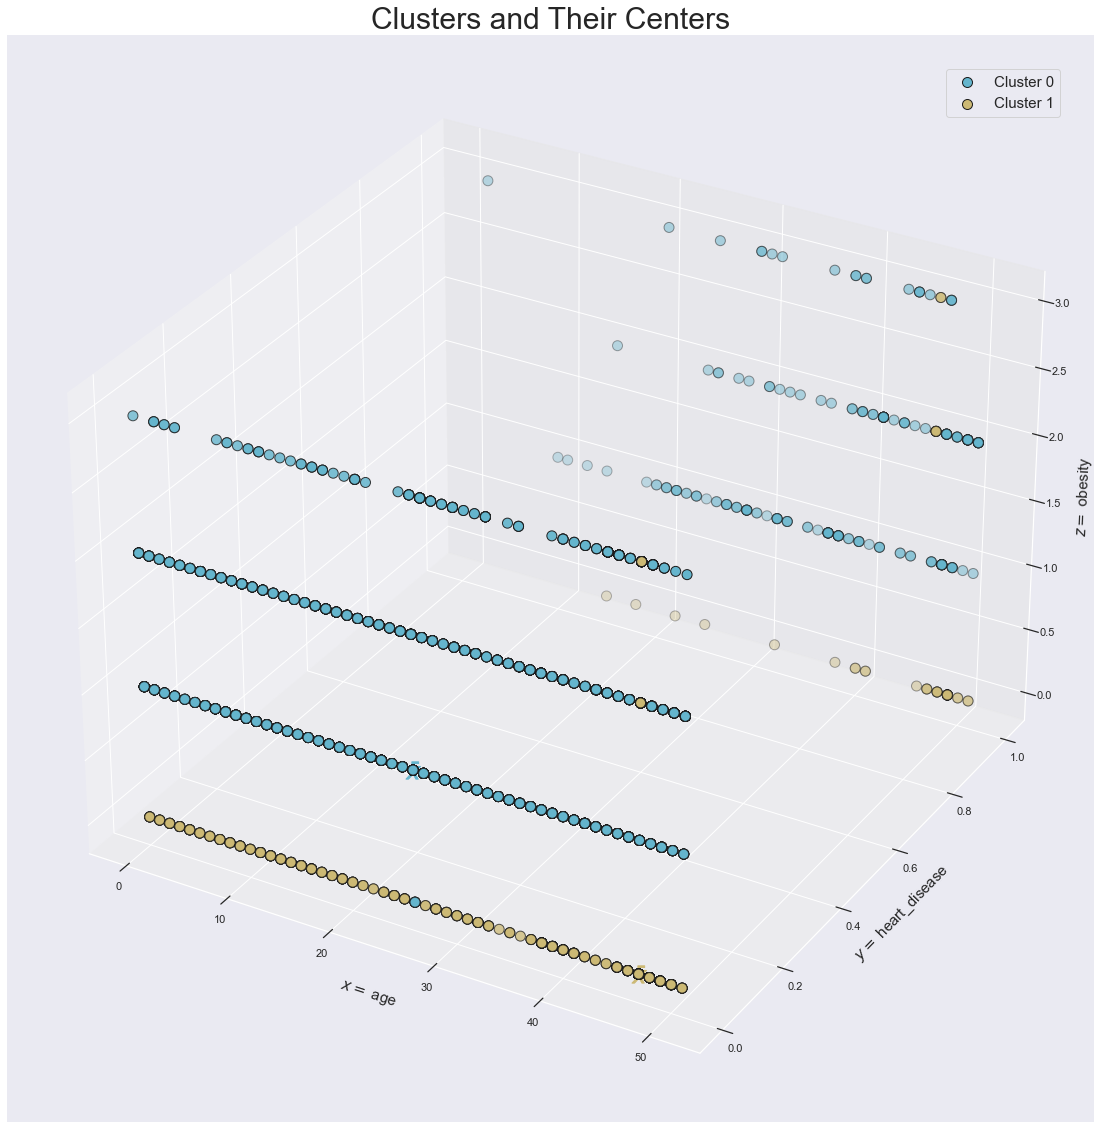

In [25]:
plot_three_d_clusters(cluster_df, center_df, 'age', 'heart_disease', 'obesity')

In [26]:
import scipy.stats as stats
# set alpha for testing significance
alpha = 0.05
# create DataFrame of samples for ANOVA testing
samples = pd.concat((cluster_df, train.stroke), axis=1)
# Perform ANOVA one-way test for null hypotesis
F, p = stats.f_oneway(samples[samples.cluster == 0].stroke,
                      samples[samples.cluster == 1].stroke,
                      samples[samples.cluster == 2].stroke,
                      samples[samples.cluster == 3].stroke,
                      samples[samples.cluster == 4].stroke)
# print fail or succeed to reject and values returned
if p < alpha:
    state = '✓ May reject'
else:
    state = '𐄂 Fail to reject'
print(f'''
      Stats
+---------------+
| F-value: {F:.2f} |  {state}
| p-value: {p:.2f} |  the null hypothesis.
+---------------+
''')


      Stats
+---------------+
| F-value: nan |  𐄂 Fail to reject
| p-value: nan |  the null hypothesis.
+---------------+



In [27]:
col_list = ['age', 'heart_disease']
explore_df = train[col_list]
explore_df = pd.DataFrame(explore_df, columns=explore_df.columns, index=explore_df.index)


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 3905.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 3905.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 3905.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 3905.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 3905.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 3833.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 3699.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Ru

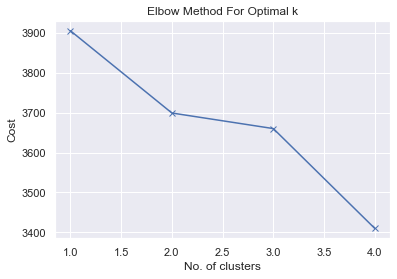

In [28]:
cost = []
K = range(1,5)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=1)
    kmode.fit_predict(explore_df)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [29]:
cluster_df, center_df, kmode=explore_clusters(explore_df, ['age', 'heart_disease'], k=3)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 3800.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 3850.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 3795.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 3847.0
Best run was number 1


In [30]:
cluster_df

,age,heart_disease,cluster
0,8,0,0
1,33,0,0
2,11,0,0
3,48,0,0
4,48,0,0
...,...,...,...
3911,50,0,0
3912,48,0,0
3913,26,0,0
3914,47,0,0


In [31]:
def plot_clusters(cluster_df, center_df, x_var, y_var):
    '''
    Takes in cluster and centers DataFrame created by explore_clusters
    function and plots the passed x and y variables that make up that
    cluster group with different colors
    '''

    # define cluster_ column for better seaborn interpretation
    cluster_df['cluster_'] = 'cluster_' + cluster_df.cluster.astype(str)
    # set scatterplot and dimensions
    plt.figure(figsize=(28, 14))
    sns.scatterplot(x=x_var, y=y_var, data=cluster_df, hue='cluster_', s=100)
    # plot cluster centers
    center_df.plot.scatter(x=x_var, y=y_var, ax=plt.gca(), s=300, c='k',
                                        edgecolor='w', marker='$\\bar{x}$')
    # set labels and legend, show
    plt.xlabel(f'\n{x_var}\n', fontsize=20)
    plt.ylabel(f'\n{y_var}\n', fontsize=20)
    plt.title('\nClusters and Their Centers\n', fontsize=30)
    plt.legend(bbox_to_anchor=(0.95,0.95), fontsize=20)

    plt.show()

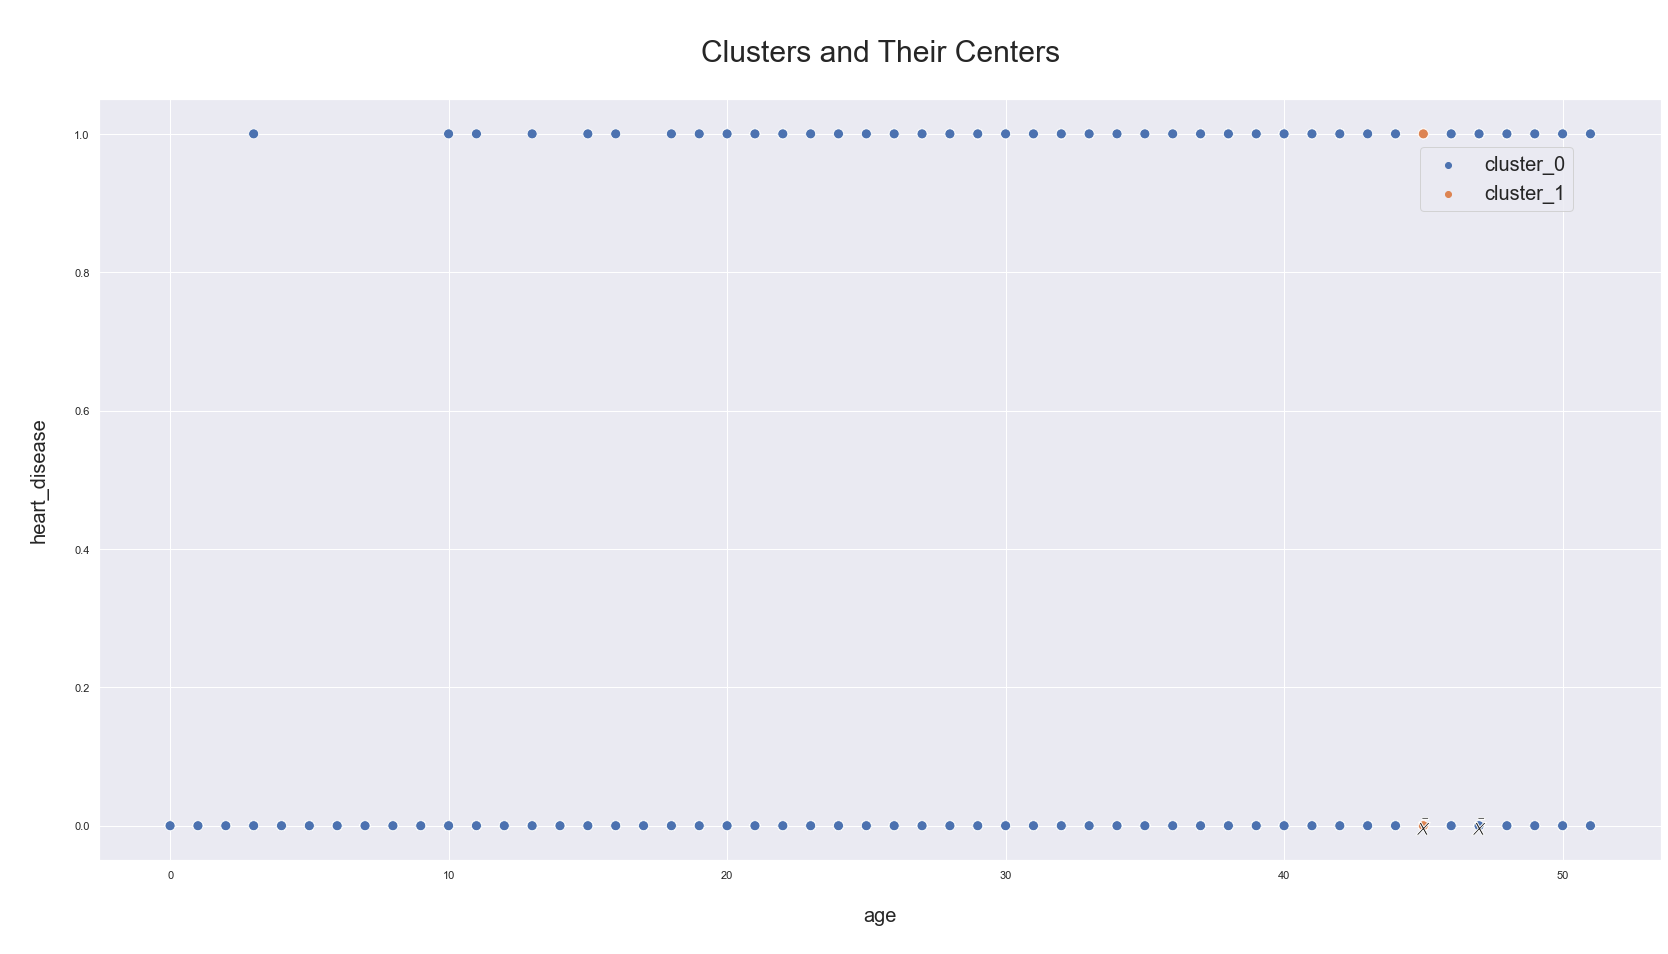

In [32]:
plot_clusters(cluster_df, center_df, 'age', 'heart_disease')

In [41]:
from scipy.stats import mannwhitneyu
alpha = 0.05
# create DataFrame of samples for ANOVA testing
samples = pd.concat((cluster_df, train.stroke), axis=1)
p = mannwhitneyu(samples[samples.cluster == 0].stroke,
                 samples[samples.cluster == 1].stroke,
                 samples[samples.cluster == 2].stroke,
                 samples[samples.cluster == 3].stroke,
                 samples[samples.cluster == 4].stroke)
# print fail or succeed to reject and values returned
if p < alpha:
    state = '✓ May reject'
else:
    state = '𐄂 Fail to reject'
print(f'''
      Stats
+---------------+
| F-value: {F:.2f} |  {state}
| p-value: {p:.2f} |  the null hypothesis.
+---------------+
''')

TypeError: mannwhitneyu() takes from 2 to 4 positional arguments but 5 were given

In [45]:
stat, p = mannwhitneyu(cluster_df.cluster_, train.stroke)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distribution (fail to reject H0)')
else:
	print('Different distribution (reject H0)')

TypeError: '<' not supported between instances of 'int' and 'str'

In [43]:
cluster_df

,age,heart_disease,cluster,cluster_
0,8,0,0,cluster_0
1,33,0,0,cluster_0
2,11,0,0,cluster_0
3,48,0,0,cluster_0
4,48,0,0,cluster_0
...,...,...,...,...
3911,50,0,0,cluster_0
3912,48,0,0,cluster_0
3913,26,0,0,cluster_0
3914,47,0,0,cluster_0


In [ ]:
# dfle = df.copy()
stroke = df['stroke'].copy()
cat_df = df[['gender', 'hypertension', 'heart_disease', 'ever_married',
              'work_type', 'Residence_type', 'smoking_status', 'obesity',
              'diabetic', 'stroke']].copy()
cat_df

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
cat_df = cat_df.apply(le.fit_transform)
cat_df.head()

In [ ]:
# y_stroke = stroke.astype('object')



new_df = df[['age','id']].copy()

new_df= pd.DataFrame(new_df)
new_df = new_df.dropna()

In [ ]:
new_df

In [ ]:
# from sklearn.preprocessing import OneHotEncoder
# # creating instance of one-hot-encoder
# enc = OneHotEncoder(handle_unknown='ignore')
# # # passing bridge-types-cat column (label encoded values of bridge_types)
# # # enc_df = pd.DataFrame(enc.fit_transform(X).toarray())
# # enc_df = enc.fit_transform(cat_df)
# # # merge with main df  on key values
# # df_enc = pd.concat([new_df, enc_df], axis=1)

# def col_coder(encoder, _df):
    
#     collector = {}
#     for col in _df.columns:
#         collector[col] = \
#             pd.DataFrame.sparse.from_spmatrix(enc.fit_transform(pd.DataFrame(_df[col].copy())))
        
#     return collector

# dic_of_dfs = col_coder(enc, cat_df)

# dic_of_dfs["diabetic"].columns = "Diabetic", "Low", "Normal"
# dic_of_dfs["ever_married"].columns = "No", "Yes"
# dic_of_dfs["gender"].columns = "Female", "Male"
# dic_of_dfs["heart_disease"].columns = "Negative", "Positive"
# dic_of_dfs["hypertension"].columns = "Negative", "Positive"
# dic_of_dfs["obesity"].columns = "Healthy", "Obese", "Overweight", "Underweight"
# dic_of_dfs["Residence_type"].columns = "Rural", "Urban"
# dic_of_dfs["smoking_status"].columns = "Unknown", "former_smoked", "never_smoked", "smokes"
# dic_of_dfs["work_type"].columns = "Govt_job", "Private", "Self-employed"


# final_df = pd.concat(dic_of_dfs, axis=1)

# cols = final_df.columns
# cols = ["_".join(col) for col in cols]

# final_df.columns = final_df.columns.droplevel(0)
# final_df.columns = cols

In [ ]:
from sklearn.model_selection import train_test_split


# for col in final_df.columns:
#     final_df[col] = final_df[col].astype('object')


split_df = pd.concat([cat_df, new_df], axis=1)
split_df.info()

In [ ]:
split_df.head()

In [ ]:
split_df= split_df.set_index('id')
split_df

### Clustering w/ KMODES

In [ ]:
# Importing Libraries

from kmodes.kmodes import KModes

In [ ]:
# Elbow curve to find optimal K
cost = []
K = range(1,5)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=1)
    kmode.fit_predict(split_df)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
kmode = KModes(n_clusters=2, init = "random", n_init = 2, verbose=1)
cluster_labels = kmode.fit_predict(split_df)

In [ ]:
cluster_labels

In [ ]:
split_df

In [ ]:
# set alpha for testing significance
alpha = 0.05
# create DataFrame of samples for ANOVA testing
samples = pd.concat((cluster_df, split_df.stroke), axis=1)
# Perform ANOVA one-way test for null hypotesis
F, p = stats.f_oneway(samples[samples.cluster == 0].stroke,
                      samples[samples.cluster == 1].stroke,
                      samples[samples.cluster == 2].stroke)
# print fail or succeed to reject and values returned
if p < alpha:
    state = '✓ May reject'
else:
    state = '𐄂 Fail to reject'
print(f'''
      Stats
+---------------+
|  F-stat: {F:.2f} |  {state}
| p-value: {p:.2f} |  the null hypothesis.
+---------------+
''')

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit_predict(X)
    ax.scatter(X.sepal_length, X.petal_length, c=clusters)
    ax.set(title='k = {}'.format(k), xlabel='sepal length', ylabel='petal length')

In [ ]:
clusterCentroidsDf = pd.DataFrame(km_cao.cluster_centroids_)
clusterCentroidsDf.columns = split_df.columns

In [ ]:
# Mode of the clusters
clusterCentroidsDf


### Using K-Mode with "Huang" initialization

In [ ]:
km_huang = KModes(n_clusters=2, init = "Huang", n_init = 1, verbose=1)
fitClusters_huang = km_huang.fit_predict(bank_cust)

In [ ]:
train.head()

In [ ]:
train.info()

In [ ]:
def split_xy(train, validate, test, target):
    '''
    Takes in the three train, validate, and test DataFrames and returns
    six X, y DataFrames after splitting the target from the X data
    '''

    # split train into X, y
    X_train = train.drop(columns=target)
    y_train = pd.DataFrame(train[target])
    # split validate into X, y
    X_validate = validate.drop(columns=target)
    y_validate = pd.DataFrame(validate[target])
    # split test into X, y
    X_test = test.drop(columns=target)
    y_test = pd.DataFrame(test[target])

    return X_train, y_train, X_validate, y_validate, X_test, y_test

X_train, y_train, X_validate, y_validate, X_test, y_test = split_xy(train, validate, test, 'stroke')


In [ ]:
print('original train', X_train.shape, y_train.shape)
print('smote train', X_train_smote.shape, y_train_smote.shape)
print('-'*80)
print('validate shape', X_validate.shape, y_validate.shape)
print('-'*80)
print('test shape', X_test.shape, y_test.shape)
print('-'*80)